General info
---
This is the coding part for the UCL 22/23 CASA module Urban Simulation (CASA0002)  
Assignment requirements avaliable [here](https://github.com/Murphy829/US22-23/blob/245e01187643b5a70bb2f5e724a45691aa0c1c03/Assessment%26MarkingScheme/AssessUrbanSim2023.pdf)  
Marking scheme avaliable [here](https://github.com/Murphy829/US22-23/blob/245e01187643b5a70bb2f5e724a45691aa0c1c03/Assessment%26MarkingScheme/UrbanSim_Marking_Scheme.pdf)  
Code is hosted [here](https://github.com/Murphy829/US22-23.git)  
Data is available [here](https://github.com/Murphy829/US22-23/tree/245e01187643b5a70bb2f5e724a45691aa0c1c03/Data)<br/> * *Please note: the datasets (including london underground graph and london_flows.csv) were preprocessed and outputed by Mateo Neira in module's Practiacal 10. The description and processing of the raw data can be found on Moodle-Week-10.*

# 0. Requirements for execution analysis

In [298]:
import sys
print(sys.version)

3.10.5 | packaged by conda-forge | (main, Jun 14 2022, 07:04:59) [GCC 10.3.0]


sys.version: 3.10.5 | packaged by conda-forge | (main, Jun 14 2022, 07:04:59) [GCC 10.3.0]

In [3]:
# Packages for data manipulation and processing
import pandas as pd
import numpy as np
# from operator import itemgetter
import urllib.request
import io

# Packages for graph & geo analysis
import geopandas as gpd
import networkx as nx
from networkx import algorithms 
from networkx.algorithms import efficiency
from networkx.algorithms import components
from networkx.algorithms.efficiency_measures import global_efficiency
from networkx.algorithms.components import connected_components

# Packages for visualisation
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator

import warnings
warnings.filterwarnings('ignore')

# 🛡️Part 1: London’s underground resilience

# **I. Topological network**

In [300]:
# Read london underground graph data
url = "https://raw.githubusercontent.com/Murphy829/US22-23/main/Data/london.graph"
response = urllib.request.urlopen(url)
content = response.read().decode('utf-8')
file = io.StringIO(content)

G = nx.read_graphml(file)

In [301]:
# Take a look at our data
print(nx.info(G))

Graph with 401 nodes and 467 edges


In [302]:
for node in G.nodes():
    G.nodes[node]['coords'] = eval(G.nodes[node]['coords'])

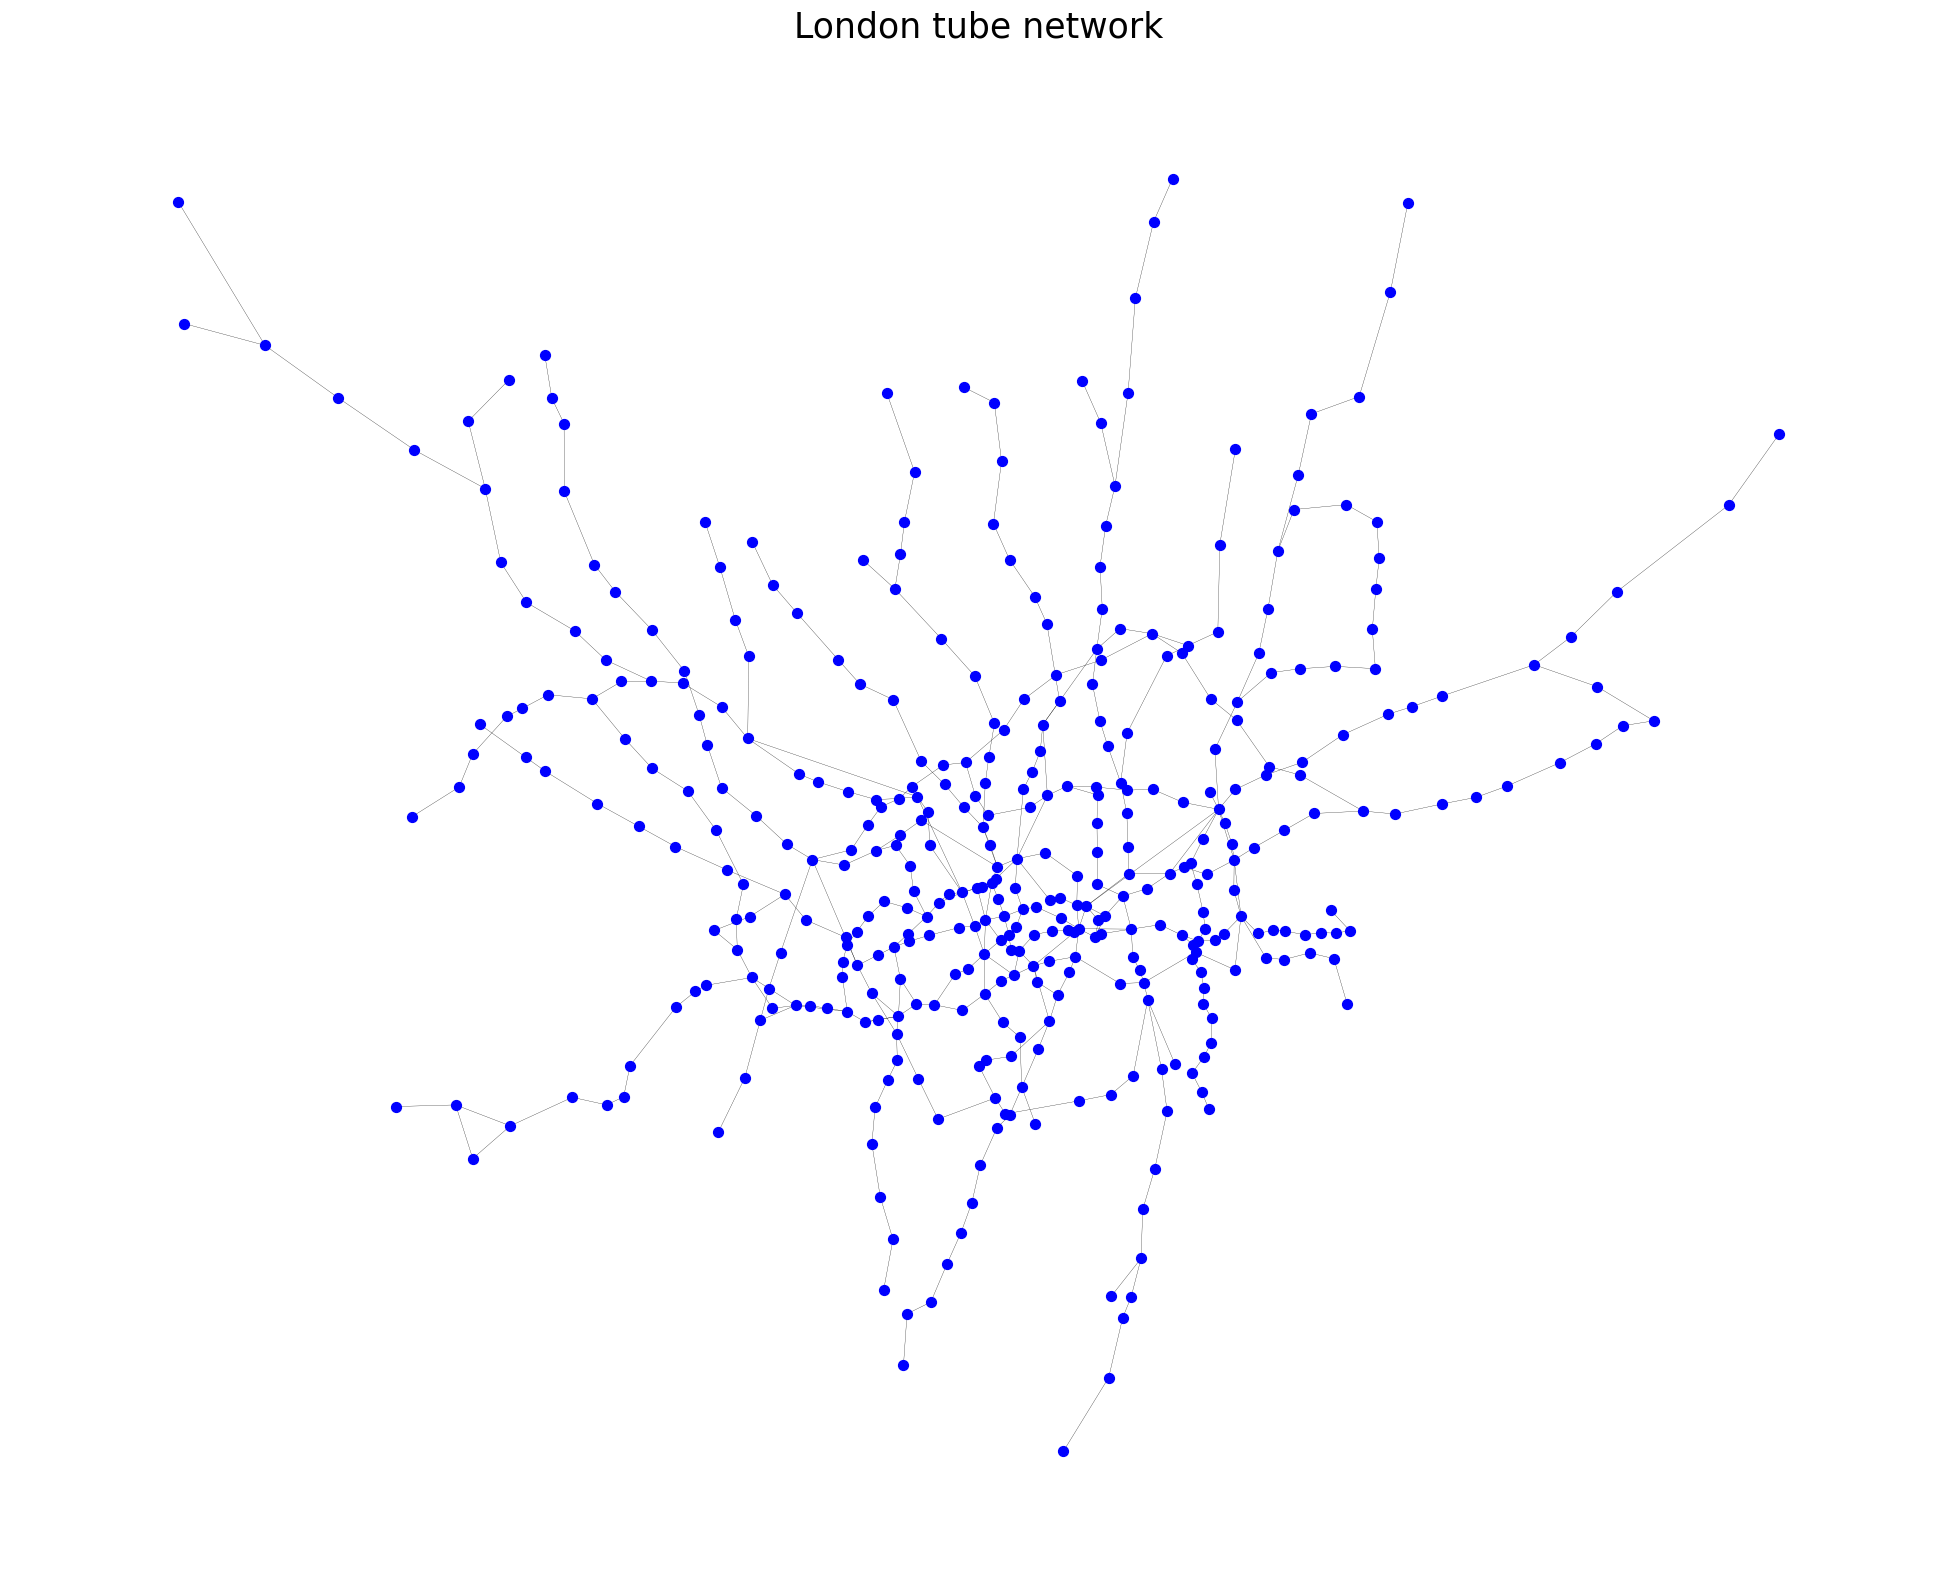

In [303]:
fig, ax = plt.subplots(figsize=(25,20))

node_labels = nx.get_node_attributes(G, 'station_name')

pos = nx.get_node_attributes(G, 'coords')

nx.draw_networkx_nodes(G,pos,node_size=50,node_color='b')
nx.draw_networkx_edges(G,pos,arrows=False,width=0.2)
nx.draw_networkx_labels(G,pos, node_labels, font_size=10, font_color='black')

plt.title("London tube network",fontsize=25)
plt.axis("off")
plt.show()

In [304]:
df = nx.to_pandas_edgelist(G)

In [83]:
df 

,source,target,length,flows,line_name
0,Earl's Court,Gloucester Road,910.121214,94382,District
1,Earl's Court,Barons Court,1504.798065,68432,Piccadilly
2,Earl's Court,West Kensington,944.065294,3196,District
3,Earl's Court,West Brompton,567.389192,34620,District
4,Earl's Court,High Street Kensington,1300.860111,17455,District
...,...,...,...,...,...
462,East Finchley,Highgate,1749.020658,25789,Northern
463,Highgate,Archway,1590.204796,30286,Northern
464,Archway,Tufnell Park,993.536112,35715,Northern
465,Tufnell Park,Kentish Town,764.601008,38298,Northern


In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 467 entries, 0 to 466
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source     467 non-null    object 
 1   target     467 non-null    object 
 2   length     467 non-null    float64
 3   flows      467 non-null    int64  
 4   line_name  467 non-null    object 
dtypes: float64(1), int64(1), object(3)
memory usage: 18.4+ KB


In [4]:
# Read london underground graph data
url_tube = "https://raw.githubusercontent.com/Murphy829/US22-23/main/Data/london_tubenetwork.graphml"
response = urllib.request.urlopen(url_tube)
content = response.read().decode('utf-8')
file = io.StringIO(content)

G_tube = nx.read_graphml(file)

In [5]:
for node in G_tube .nodes():
    G_tube .nodes[node]['coords'] = eval(G_tube.nodes[node]['coords'])

In [7]:
nod_name1={(e1,e2):(G_tube.nodes[e1]['station_name']) for e1, e2 in G_tube .edges()}
nod_name2={(e1,e2):(G_tube.nodes[e2]['station_name']) for e1, e2 in G_tube .edges()}

nx.set_edge_attributes(G_tube ,nod_name1,'station_name')
nx.set_edge_attributes(G_tube ,nod_name2,'station_name')

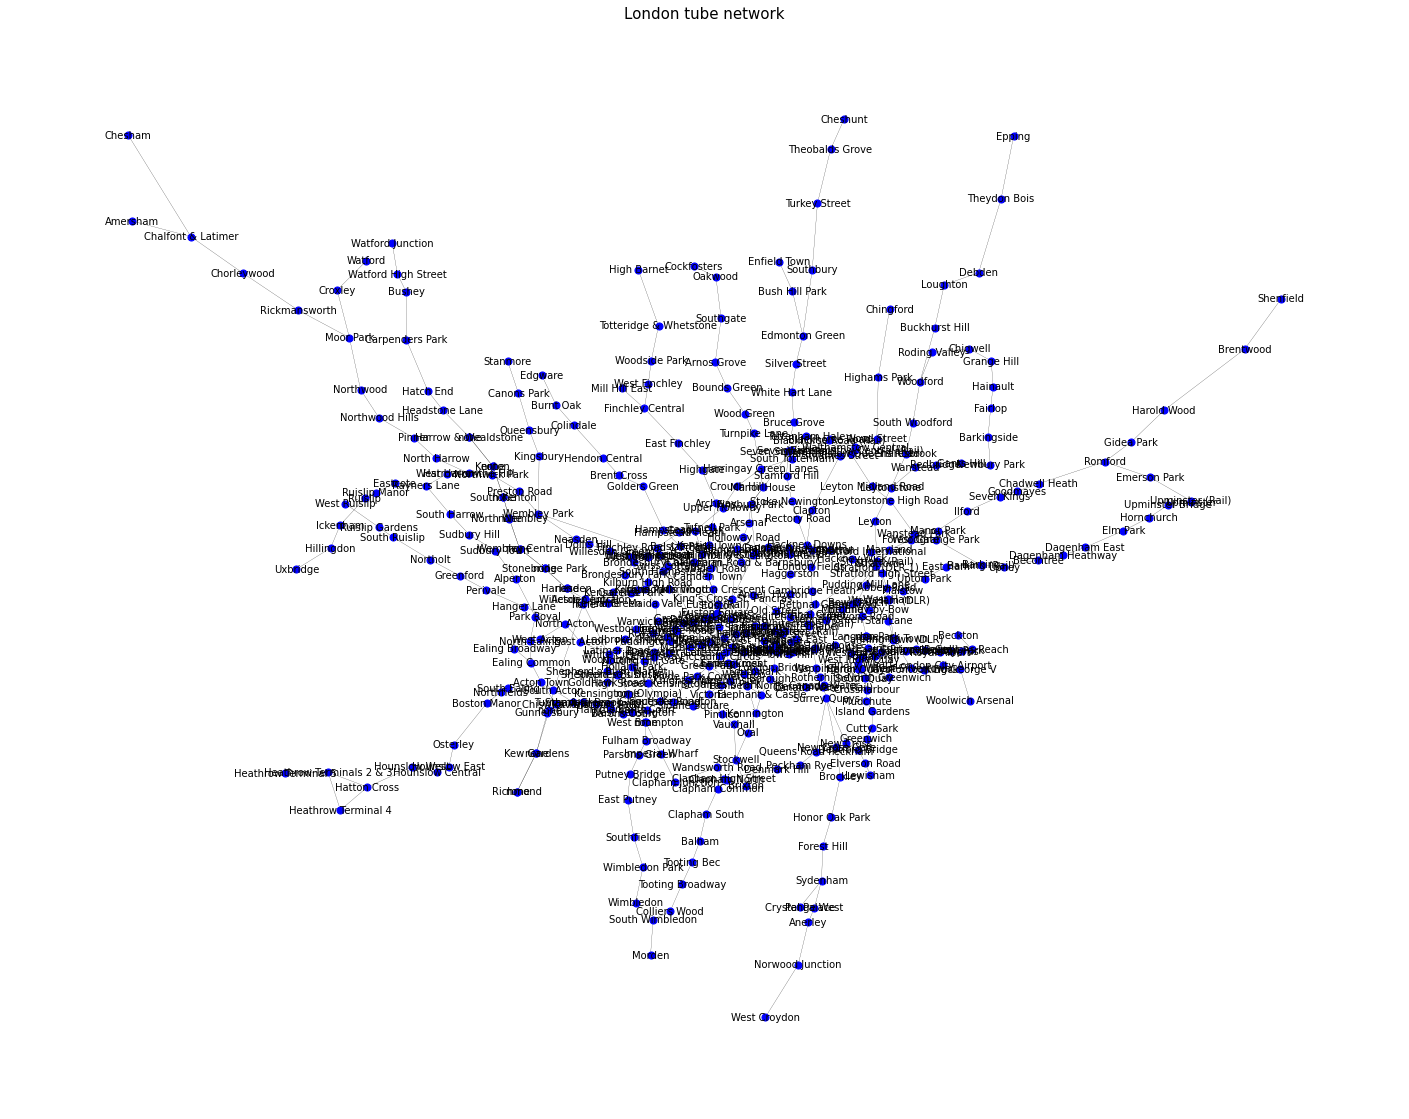

In [8]:
# Let's plot the tube network! 

# We can plot the tube network with the names of the stations as labels
fig, ax = plt.subplots(figsize=(25,20))

node_labels = nx.get_node_attributes(G_tube , 'station_name')

pos = nx.get_node_attributes(G_tube , 'coords')

nx.draw_networkx_nodes(G_tube ,pos,node_size=50,node_color='b')
nx.draw_networkx_edges(G_tube ,pos,arrows=False,width=0.2)
nx.draw_networkx_labels(G_tube ,pos, node_labels, font_size=10, font_color='black')

plt.title("London tube network",fontsize=15)
plt.axis("off")
plt.show()

## I.1. Centrality Measures

Select 3 centrality measures to characterise nodes, aiming at identifying the most important nodes in 
this particular network.  
- Degree centrality
- Closeness centrality
- Betweeness centrality  

Definitions can be found in the submitted essay.

### a) Non-sequential

#### degree centrality

In [305]:
# Top 10 degree centrality
degree_centrality = pd.DataFrame(nx.degree(G), columns=['degree(nonseq)', 'value']) \
                      .sort_values(by='value', ascending=False) \
                      .iloc[:10]
degree_centrality

,degree(nonseq),value
125,Stratford,9
83,Bank and Monument,8
107,Baker Street,7
16,King's Cross St. Pancras,7
0,Earl's Court,6
126,Canning Town,6
91,West Ham,6
106,Liverpool Street,6
10,Green Park,6
226,Oxford Circus,6


#### closeness centrality

In [306]:
# Top 10 closeness centrality
closeness_centrality = pd.DataFrame.from_dict(nx.closeness_centrality(G, distance='distance'), 
                                               orient='index', columns=['value']) \
                         .rename_axis('closeness(nonseq)').reset_index() \
                         .sort_values(by='value', ascending=False) \
                         .iloc[:10]
closeness_centrality

,closeness(nonseq),value
10,Green Park,0.114778
83,Bank and Monument,0.113572
16,King's Cross St. Pancras,0.113443
77,Westminster,0.112549
133,Waterloo,0.112265
226,Oxford Circus,0.111204
134,Bond Street,0.110988
372,Angel,0.110742
110,Farringdon,0.110742
112,Moorgate,0.110314


#### betweeness centrality

In [307]:
# Top 10 betweeness centrality
betweenness_centrality = pd.DataFrame.from_dict(nx.betweenness_centrality(G), 
                                                 orient='index', columns=['value']) \
                            .rename_axis('betweenness(nonseq)').reset_index() \
                            .sort_values(by='value', ascending=False) \
                            .iloc[:10]
betweenness_centrality

,betweenness(nonseq),value
125,Stratford,0.297846
83,Bank and Monument,0.290489
106,Liverpool Street,0.270807
16,King's Cross St. Pancras,0.255307
133,Waterloo,0.243921
10,Green Park,0.215835
235,Euston,0.208324
77,Westminster,0.203335
107,Baker Street,0.191568
137,Finchley Road,0.165085


In [130]:
# Merge 3 centrality results in one df
top_stations_nonseq = pd.concat([degree_centrality.reset_index(drop=True),
                          closeness_centrality.reset_index(drop=True),
                          betweenness_centrality.reset_index(drop=True)], axis=1)

top_stations_nonseq .insert(0,'Rank',range(1,11))

top_stations_nonseq

,Rank,degree(nonseq),value,closeness(nonseq),value,betweenness(nonseq),value
0,1,Stratford,9,Green Park,0.114778,Stratford,0.297846
1,2,Bank and Monument,8,Bank and Monument,0.113572,Bank and Monument,0.290489
2,3,Baker Street,7,King's Cross St. Pancras,0.113443,Liverpool Street,0.270807
3,4,King's Cross St. Pancras,7,Westminster,0.112549,King's Cross St. Pancras,0.255307
4,5,Earl's Court,6,Waterloo,0.112265,Waterloo,0.243921
5,6,Canning Town,6,Oxford Circus,0.111204,Green Park,0.215835
6,7,West Ham,6,Bond Street,0.110988,Euston,0.208324
7,8,Liverpool Street,6,Angel,0.110742,Westminster,0.203335
8,9,Green Park,6,Farringdon,0.110742,Baker Street,0.191568
9,10,Oxford Circus,6,Moorgate,0.110314,Finchley Road,0.165085


### b) Sequential

#### degree centrality

In [308]:
# Top 10 degree centrality applying sequential removal
degree_centrality_seq=[]
G_dc_seq=G.copy()
for i in range(0,10):
    degree=nx.degree(G_dc_seq)
    nx.set_node_attributes(G_dc_seq,dict(degree),'degree')
    degree_df=pd.DataFrame.from_dict(dict(degree),columns=['degree'],orient='index')
    node6=list(degree_df.sort_values('degree',axis = 0,ascending = False).index)
    degree_centrality_seq.append(node6[0])
    G_dc_seq.remove_nodes_from([node6[0]])

degree_centrality_seq

['Stratford',
 'Bank and Monument',
 "King's Cross St. Pancras",
 'Baker Street',
 "Earl's Court",
 'Oxford Circus',
 'Canning Town',
 'Willesden Junction',
 'Turnham Green',
 'Green Park']

#### closeness centrality

In [309]:
# Top 10 closeness centrality applying sequential removal
closeness_centrality_seq=[]
G_cc_seq=G.copy()
for i in range(0,10):
    closeness_seq=nx.closeness_centrality(G_cc_seq)
    nx.set_node_attributes(G_cc_seq,closeness_seq,'closeness')
    closeness_df=pd.DataFrame.from_dict(closeness_seq,columns=['closeness'],orient='index')
    node5=list(closeness_df.sort_values('closeness',axis = 0,ascending = False).index)
    closeness_centrality_seq.append(node5[0])
    G_cc_seq.remove_nodes_from([node5[0]])
    
closeness_centrality_seq

['Green Park',
 "King's Cross St. Pancras",
 'Waterloo',
 'Bank and Monument',
 'West Hampstead',
 'Canada Water',
 'Stratford',
 "Earl's Court",
 "Shepherd's Bush",
 'Oxford Circus']

#### betweeness centrality

In [310]:
# Top 10 betweeness centrality applying sequential removal
betweeness_centrality_seq=[]
G_bc_seq=G.copy()

for i in range(0,10):
    # recalculate the centrality values and remove the most largest one
    betweeness_seq=nx.betweenness_centrality(G_bc_seq,normalized=False)
    nx.set_node_attributes(G_bc_seq,betweeness_seq,'betweenness')
    betweenness_df=pd.DataFrame.from_dict(betweeness_seq,columns=['betweenness'],orient='index')
    node4=list(betweenness_df.sort_values('betweenness',axis = 0,ascending = False).index)
    betweeness_centrality_seq.append(node4[0])
    G_bc_seq.remove_nodes_from([node4[0]])
    
betweeness_centrality_seq

['Stratford',
 "King's Cross St. Pancras",
 'Waterloo',
 'Bank and Monument',
 'Canada Water',
 'West Hampstead',
 "Earl's Court",
 "Shepherd's Bush",
 'Euston',
 'Baker Street']

In [125]:
top_stations_seq= pd.DataFrame({'degree(seq)': degree_centrality_seq, 'closeness(seq)': closeness_centrality_seq, 'betweeness(seq)': betweeness_centrality_seq})
top_stations_seq .insert(0,'Rank',range(1,11))
top_stations_seq

,Rank,degree(seq),closeness(seq),betweeness(seq)
0,1,Stratford,Green Park,Stratford
1,2,Bank and Monument,King's Cross St. Pancras,King's Cross St. Pancras
2,3,King's Cross St. Pancras,Waterloo,Waterloo
3,4,Baker Street,Bank and Monument,Bank and Monument
4,5,Earl's Court,West Hampstead,Canada Water
5,6,Oxford Circus,Canada Water,West Hampstead
6,7,Canning Town,Stratford,Earl's Court
7,8,Willesden Junction,Earl's Court,Shepherd's Bush
8,9,Turnham Green,Shepherd's Bush,Euston
9,10,Green Park,Oxford Circus,Baker Street


In [131]:
# merge 2 dfs
top_sataions = pd.merge(top_stations_nonseq.drop('value', axis=1), top_stations_seq, on='Rank')
top_sataions

,Rank,degree(nonseq),closeness(nonseq),betweenness(nonseq),degree(seq),closeness(seq),betweeness(seq)
0,1,Stratford,Green Park,Stratford,Stratford,Green Park,Stratford
1,2,Bank and Monument,Bank and Monument,Bank and Monument,Bank and Monument,King's Cross St. Pancras,King's Cross St. Pancras
2,3,Baker Street,King's Cross St. Pancras,Liverpool Street,King's Cross St. Pancras,Waterloo,Waterloo
3,4,King's Cross St. Pancras,Westminster,King's Cross St. Pancras,Baker Street,Bank and Monument,Bank and Monument
4,5,Earl's Court,Waterloo,Waterloo,Earl's Court,West Hampstead,Canada Water
5,6,Canning Town,Oxford Circus,Green Park,Oxford Circus,Canada Water,West Hampstead
6,7,West Ham,Bond Street,Euston,Canning Town,Stratford,Earl's Court
7,8,Liverpool Street,Angel,Westminster,Willesden Junction,Earl's Court,Shepherd's Bush
8,9,Green Park,Farringdon,Baker Street,Turnham Green,Shepherd's Bush,Euston
9,10,Oxford Circus,Moorgate,Finchley Road,Green Park,Oxford Circus,Baker Street


In [133]:
# # Output rank table
# top_stations_nonseq.to_csv('Output/top_stations_nonseq.csv', index=False)
# top_stations_seq.to_csv('Output/top_stations_seq.csv', index=False)
# top_sataions.to_csv('Output/top_stations.csv', index=False)

## I.2. Measure(s) to assess impact

- Global efficiency
- Size of the maximal connected sub-graph

## I.3. Node removal (Analysis)

The methods used here is global efficiency of the network and size of the maximal connected sub-graph.   
Gobal efficiency measurement can be done via the function global_efficiency() in networks package.   
Size of the maximal connected sub-graph can be calculated by the function rsmcs() which is defined as follows.  

``global_dc_nonseq``(Global efficiency based on Non-sequential removal & degree centrality),   
``global_cc_nonseq``(Global efficiency based on Non-sequential removal & closeness centrality),   
``global_bc_nonseq``(Global efficiency based on Non-sequential removal & betweenness centrality),   
``size_dc_nonseq``(Size of the maximal connected sub-graph based on Non-sequential removal & degree centrality),   
``size_cc_nonseq``(Size of the maximal connected sub-graph based on Non-sequential removal & closeness centrality),   
``size_bc_nonseq``(Size of the maximal connected sub-graph based on Non-sequential removal & betweenness centrality),   
``global_dc_seq``(Global efficiency based on Sequential removal & degree centrality),   
``global_cc_seq``(Global efficiency based on Sequential removal & closeness centrality),   
``global_bc_seq``(Global efficiency based on Sequential removal & betweenness centrality),   
``size_dc_seq``(Size of the maximal connected sub-graph based on Sequential removal & degree centrality),   
``size_cc_seq``(Size of the maximal connected sub-graph based on Sequential removal & closeness centrality),   
``size_bc_seq``(Size of the maximal connected sub-graph based on Sequential removal & betweenness centrality)

In [311]:
def rsmcs(g):
    '''
    This function is the second method to evaluate the impact on the network after nodes removal.
    It gets the value of relative size of the maximal connected sub-graph.
    '''
    return len(max(nx.connected_components(g), key=len))/401

### a) Non-sequential

In [312]:
# degree_centrality
# create a list that contain the node's coordinations by order
degree_centrality=nx.degree_centrality(G)
degree_df=pd.DataFrame.from_dict(dict(degree_centrality),columns=['degree_centrality'],orient='index')
node1=list(degree_df.sort_values('degree_centrality',axis = 0,ascending = False).index)
#create a list to store the score after every time remova
size_dc_nonseq=[]
global_dc_nonseq=[]
g_1=G.copy()
#remove the node one by one, after every removel, calculate the score
for i in range(0,len(list(G.nodes))):
    size_dc_nonseq.append(rsmcs(g_1))
    global_dc_nonseq.append(global_efficiency(g_1))
    g_1.remove_nodes_from([node1[i]])

In [313]:
# closeness centrality
closeness=nx.closeness_centrality(G)
closeness_df=pd.DataFrame.from_dict(closeness,columns=['closeness'],orient='index')
node3=list(closeness_df.sort_values('closeness',axis = 0,ascending = False).index)
size_cc_nonseq=[]
global_cc_nonseq=[]
g_2=G.copy()
for i in range(0,len(list(G.nodes))):
    size_cc_nonseq.append(rsmcs(g_2))
    global_cc_nonseq.append(global_efficiency(g_2))
    g_2.remove_nodes_from([node3[i]])

In [314]:
# betweenness centrality
# create a list that contain the node's coordinations by order
bet_london_t=nx.betweenness_centrality(G, normalized=False)
betweenness_df=pd.DataFrame.from_dict(bet_london_t,columns=['betweenness'],orient='index')
node2=list(betweenness_df.sort_values('betweenness',axis = 0,ascending = False).index)

#create a list to store the score after every time removal
size_bc_nonseq=[]
global_bc_nonseq=[]
g_3=G.copy()

#remove the node one by one, after every removel, calculate the score
for i in range(0,len(list(G.nodes))):
    size_bc_nonseq.append(rsmcs(g_3))
    global_bc_nonseq.append(global_efficiency(g_3))
    g_3.remove_nodes_from([node2[i]])

### b) Sequential

In [315]:
# degree_centrality
size_dc_seq=[]
global_dc_seq=[]
g_4=G.copy()
for i in range(0,len(list(G.nodes))):
    size_dc_seq.append(rsmcs(g_4))
    global_dc_seq.append(global_efficiency(g_4))
    degree_centrality=nx.degree_centrality(g_4)
    nx.set_node_attributes(g_4,dict(degree_centrality),'degree_centrality')
    degree_df=pd.DataFrame.from_dict(dict(degree_centrality),columns=['degree_centrality'],orient='index')
    node4=list(degree_df.sort_values('degree_centrality',axis = 0,ascending = False).index)
    g_4.remove_nodes_from([node4[0]])

In [316]:
# closeness centrality
size_cc_seq=[]
global_cc_seq=[]
g_5=G.copy()
for i in range(0,len(list(G.nodes))):
    size_cc_seq.append(rsmcs(g_5))
    global_cc_seq.append(global_efficiency(g_5))
    closeness=nx.closeness_centrality(g_5)
    nx.set_node_attributes(g_5,closeness,'closeness')
    closeness_df=pd.DataFrame.from_dict(closeness,columns=['closeness'],orient='index')
    node6=list(closeness_df.sort_values('closeness',axis = 0,ascending = False).index)
    g_5.remove_nodes_from([node6[0]])

In [317]:
# betweenness centrality
size_bc_seq=[]
global_bc_seq=[]
g_6=G.copy()

#remove the node one by one, after every removel, calculate the score and recalculate the centrality value
for i in range(0,len(list(G.nodes))):
    size_bc_seq.append(rsmcs(g_6))
    global_bc_seq.append(global_efficiency(g_6))
    # recalculate the centrality values and remove the most largest one
    bet_london_t=nx.betweenness_centrality(g_6, normalized=False)
    nx.set_node_attributes(g_6,bet_london_t,'betweenness')
    betweenness_df=pd.DataFrame.from_dict(bet_london_t,columns=['betweenness'],orient='index')
    node5=list(betweenness_df.sort_values('betweenness',axis = 0,ascending = False).index)
    g_6.remove_nodes_from([node5[0]])

In [318]:
# Normaized data
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [319]:
#check the max value
print('The initial network\'s Size of the maximal connected sub-graph is '+ str(size_dc_seq[0]))
print('The initial network\'s Global efficency is '+ str(global_dc_seq[0]))

The initial network's Size of the maximal connected sub-graph is 1.0
The initial network's Global efficency is 0.10125619359722211


In [320]:
size_dc_seq = NormalizeData(size_dc_seq[0:100])
size_cc_seq = NormalizeData(size_cc_seq[0:100])
size_bc_seq = NormalizeData(size_bc_seq[0:100])
size_dc_nonseq = NormalizeData(size_dc_nonseq[0:100])
size_cc_nonseq = NormalizeData(size_cc_nonseq[0:100])
size_bc_nonseq = NormalizeData(size_bc_nonseq[0:100])

In [321]:
global_dc_seq =  NormalizeData(global_dc_seq[0:100])
global_cc_seq =  NormalizeData(global_cc_seq[0:100])
global_bc_seq =  NormalizeData(global_bc_seq[0:100])
global_dc_nonseq =  NormalizeData(global_dc_nonseq[0:100])
global_cc_nonseq =  NormalizeData(global_cc_nonseq[0:100])
global_bc_nonseq =  NormalizeData(global_bc_nonseq[0:100])

### Plot results

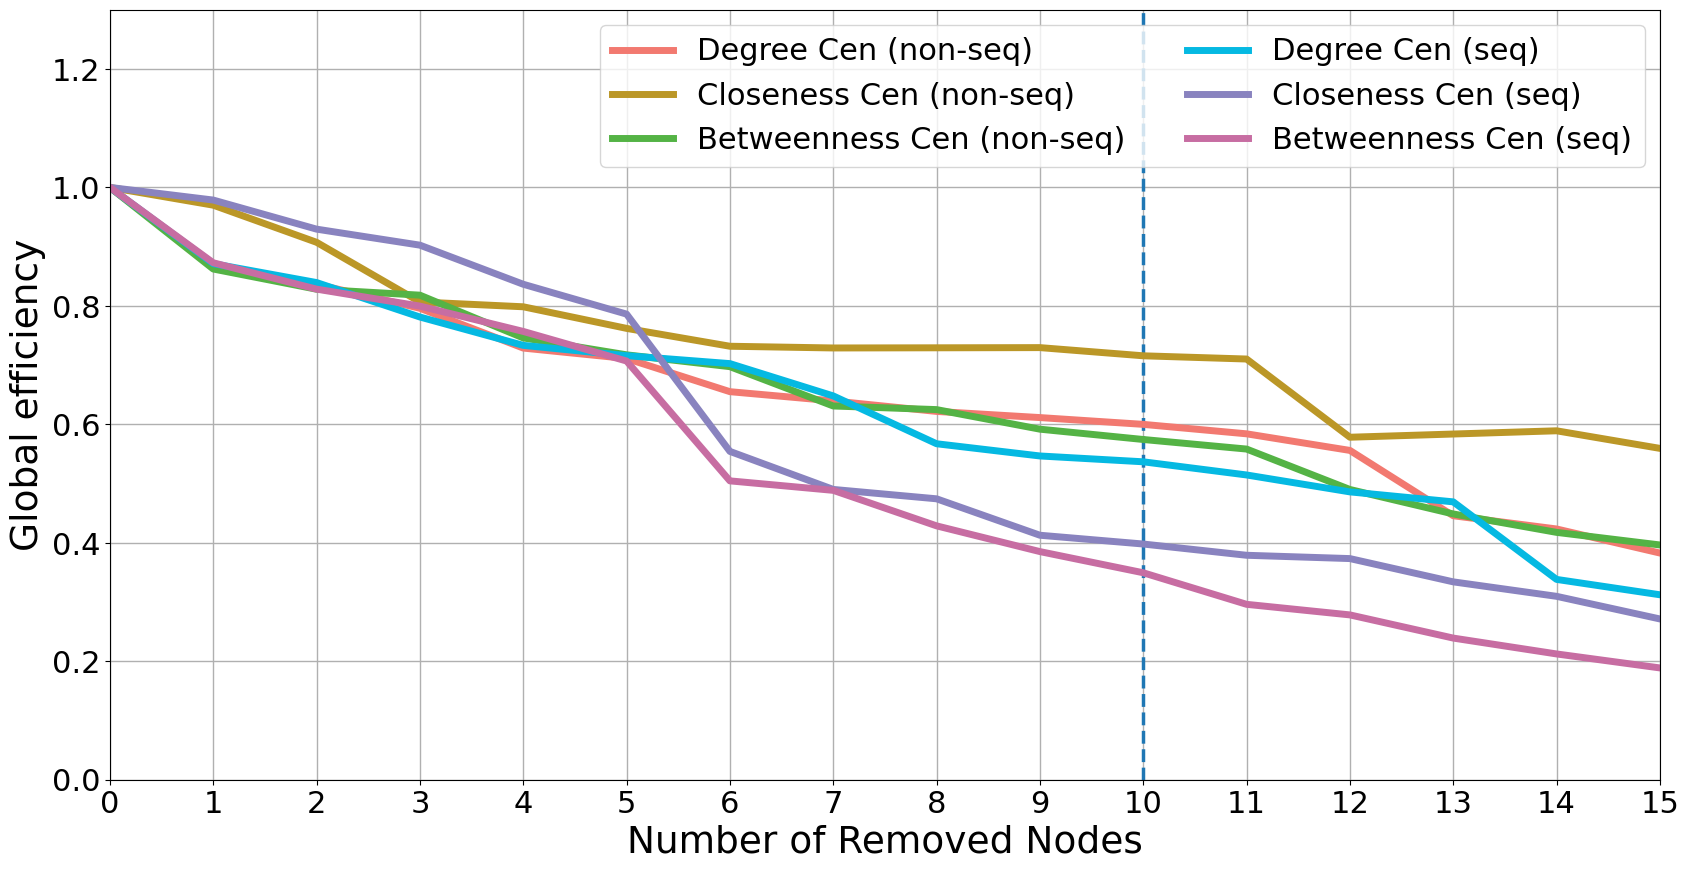

In [322]:
plt.style.use('default')
plt.subplots(figsize=(20,10))

plt.xlabel('Number of Removed Nodes',fontsize=27)
plt.ylabel('Global efficiency',fontsize=27)
plt.xticks(range(0,31,1), fontsize=22)
plt.yticks(fontsize=22)
x=range(0,100)

plt.plot([10,10],[0,1.3],'--',alpha=1,linewidth=2.5)
plt.grid(True, linewidth=1)

plt.xlim(xmax=15,xmin=0)
plt.ylim(ymax=1.3,ymin=0)

plt.plot(x, global_dc_nonseq, color=color1,label='Degree Cen (non-seq)', linewidth=5, markersize=10)
plt.plot(x, global_cc_nonseq, color=color2,label='Closeness Cen (non-seq)', linewidth=5, markersize=10)
plt.plot(x, global_bc_nonseq, color=color3,label='Betweenness Cen (non-seq)', linewidth=5, markersize=10)
plt.plot(x, global_dc_seq, color=color4,label='Degree Cen (seq)', linewidth=5, markersize=10)
plt.plot(x, global_cc_seq, color=color5,label='Closeness Cen (seq)', linewidth=5, markersize=10)
plt.plot(x, global_bc_seq, color=color6,label='Betweenness Cen (seq)', linewidth=5, markersize=10)

plt.legend(loc=1,ncol=2,fontsize=22)
plt.savefig('Output/Figure1a.png', dpi=300)
plt.show()

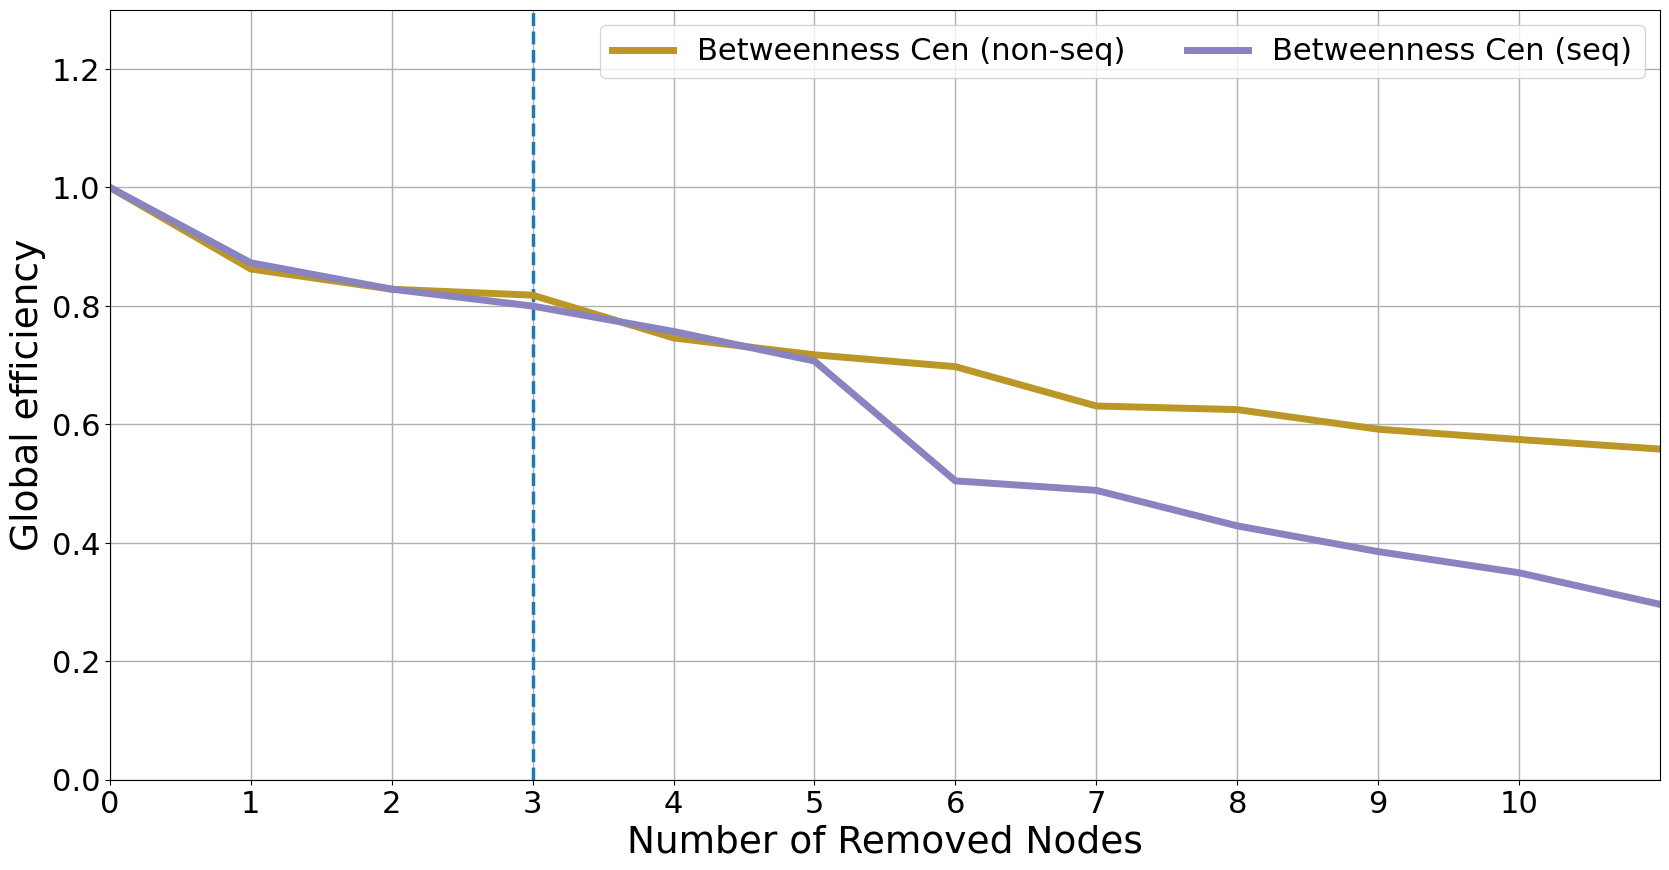

In [328]:
plt.style.use('default')
plt.subplots(figsize=(20,10))

plt.xlabel('Number of Removed Nodes',fontsize=27)
plt.ylabel('Global efficiency',fontsize=27)
plt.xticks(range(0,11,1), fontsize=22)
plt.yticks(fontsize=22)
x=range(0,100)

plt.plot([3,3],[0,1.3],'--',alpha=1,linewidth=2.5)
plt.grid(True, linewidth=1)

plt.xlim(xmax=11,xmin=0)
plt.ylim(ymax=1.3,ymin=0)

# plt.plot(x, global_dc_nonseq, color=color1,label='Degree Cen (non-seq)', linewidth=5, markersize=10)
# plt.plot(x, global_cc_nonseq, color=color3,label='Closeness Cen (non-seq)', linewidth=5, markersize=10)
plt.plot(x, global_bc_nonseq, color=color2,label='Betweenness Cen (non-seq)', linewidth=5, markersize=10)
# plt.plot(x, global_dc_seq, color=color4,label='Degree Cen (seq)', linewidth=5, markersize=10)
# plt.plot(x, global_cc_seq, color=color6,label='Closeness Cen (seq)', linewidth=5, markersize=10)
plt.plot(x, global_bc_seq, color=color5,label='Betweenness Cen (seq)', linewidth=5, markersize=10)

plt.legend(loc=1,ncol=2,fontsize=22)
plt.savefig('Output/Figure4b.png', dpi=300)
plt.show()

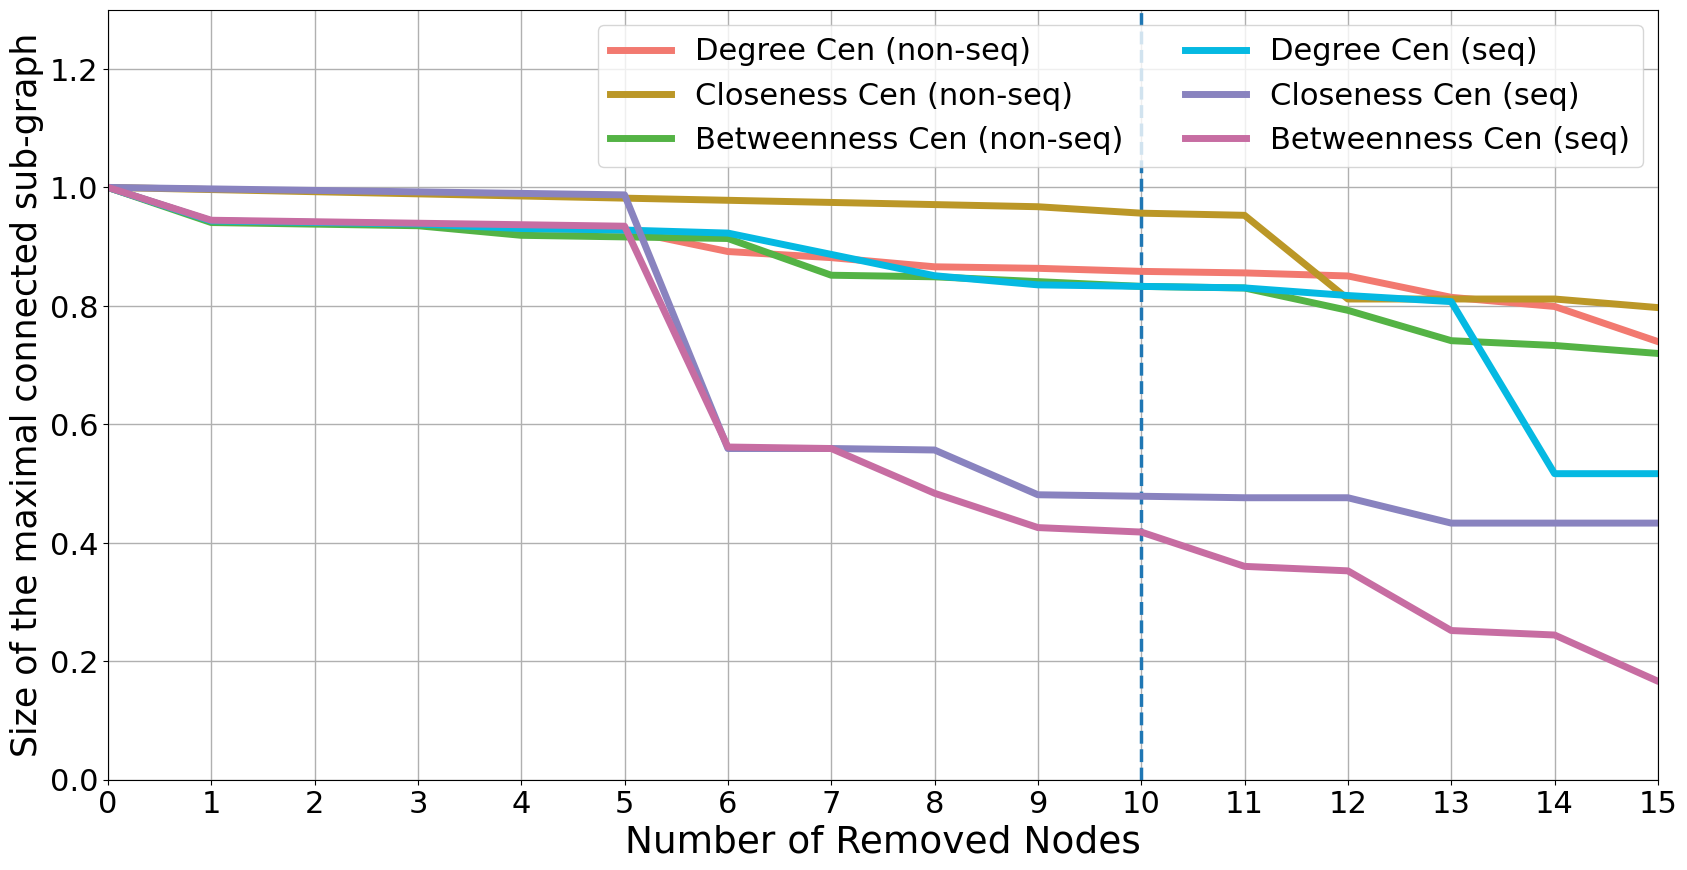

In [254]:
plt.style.use('default')
plt.subplots(figsize=(20,10))

plt.xlabel('Number of Removed Nodes',fontsize=27)
plt.ylabel('Size of the maximal connected sub-graph',fontsize=25)
plt.xticks(range(0,31,1), fontsize=22)
plt.yticks(fontsize=22)
x=range(0,100)

plt.plot([10,10],[0,1.3],'--',alpha=1,linewidth=2.5)
plt.grid(True, linewidth=1)

plt.xlim(xmax=15,xmin=0)
plt.ylim(ymax=1.3,ymin=0)

color1 = '#F27970'
color2 = '#BB9727'
color3 = '#54B345' 
color4 = '#05B9E2'
color5 = '#8983BF'
color6 = '#C76DA2'

plt.plot(x, size_dc_nonseq, color=color1,label='Degree Cen (non-seq)', linewidth=5, markersize=10)
plt.plot(x, size_cc_nonseq, color=color2,label='Closeness Cen (non-seq)', linewidth=5, markersize=10)
plt.plot(x, size_bc_nonseq, color=color3,label='Betweenness Cen (non-seq)', linewidth=5, markersize=10)
plt.plot(x, size_dc_seq, color=color4,label='Degree Cen (seq)', linewidth=5, markersize=10)
plt.plot(x, size_cc_seq, color=color5,label='Closeness Cen (seq)', linewidth=5, markersize=10)
plt.plot(x, size_bc_seq, color=color6,label='Betweenness Cen (seq)', linewidth=5, markersize=10)

plt.legend(loc=1,ncol=2,fontsize=22)
plt.savefig('Output/Figure1b.png', dpi=300)
plt.show()

In [28]:
# When 10 nodes are removed from the network, the efficiency (based on Size of the maximal connected sub-graph) decreases by
data = {'Centrality Measure': ['Degree(nonseq)', 'Closeness(nonseq)', 'Betweenness(nonseq)', 'Degree (seq)', 'Closeness (seq)', 'Betweenness (seq)'],
        'MCSG Efficiency Decrease (%)': 
        [round((size_dc_nonseq[0]-size_dc_nonseq[10])/size_dc_nonseq[0]*100, 2),
                                    round((size_cc_nonseq[0]-size_cc_nonseq[10])/size_cc_nonseq[0]*100, 2),
                                    round((size_bc_nonseq[0]-size_bc_nonseq[10])/size_bc_nonseq[0]*100, 2),
                                    round((size_dc_seq[0]-size_dc_seq[10])/size_dc_seq[0]*100, 2),
                                    round((size_cc_seq[0]-size_cc_seq[10])/size_cc_seq[0]*100, 2),
                                    round((size_bc_seq[0]-size_bc_seq[10])/size_bc_seq[0]*100, 2)]}
df_MCSG = pd.DataFrame(data)

print(df_MCSG)


    Centrality Measure  MCSG Efficiency Decrease (%)
0       Degree(nonseq)                         14.18
1    Closeness(nonseq)                          4.35
2  Betweenness(nonseq)                         16.71
3         Degree (seq)                         16.71
4      Closeness (seq)                         52.14
5    Betweenness (seq)                         58.19


In [29]:
# When 10 nodes are removed from the network, the efficiency (based on Global efficiency) decreases by
data = {'Centrality Measure': ['Degree(nonseq)', 'Closeness(nonseq)', 'Betweenness(nonseq)', 'Degree (seq)', 'Closeness (seq)', 'Betweenness (seq)'],
        'Global Efficiency Decrease (%)':
        [round((global_dc_nonseq[0]-global_dc_nonseq[10])/global_dc_nonseq[0]*100, 2),
        round((global_cc_nonseq[0]-global_cc_nonseq[10])/global_cc_nonseq[0]*100, 2),
        round((global_bc_nonseq[0]-global_bc_nonseq[10])/global_bc_nonseq[0]*100, 2),
        round((global_dc_seq[0]-global_dc_seq[10])/global_dc_seq[0]*100, 2),
        round((global_cc_seq[0]-global_cc_seq[10])/global_cc_seq[0]*100, 2),
        round((global_bc_seq[0]-global_bc_seq[10])/global_bc_seq[0]*100, 2)]}
df_global = pd.DataFrame(data)

print(df_global)


    Centrality Measure  Global Efficiency Decrease (%)
0       Degree(nonseq)                           40.00
1    Closeness(nonseq)                           28.43
2  Betweenness(nonseq)                           42.56
3         Degree (seq)                           46.32
4      Closeness (seq)                           60.21
5    Betweenness (seq)                           65.06


# **II. Flows: weighted network**

In [30]:
london_flow = pd.read_csv('https://raw.githubusercontent.com/Murphy829/US22-23/main/Data/london_flows.csv')
london_flow.head()

,station_origin,station_destination,flows,population,jobs,distance
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097
1,Abbey Road,Beckton,1,599,442,8510.121774
2,Abbey Road,Blackwall,3,599,665,3775.448872
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220
4,Abbey Road,Canning Town,37,599,15428,2228.923167


## II.1. Old vs new measure

In [229]:
G_un=G.to_undirected()

In [230]:
new_weight={}

for e1,e2,c in G_un.edges(data='flows'):
    if c==0:
        new_weight[(e1,e2)]=0
    else:
        new_weight[(e1,e2)]=1/c

nx.set_edge_attributes(G_un,new_weight,'new_weight')

nx.to_pandas_edgelist(G_un)

,source,target,length,flows,new_weight,line_name
0,Earl's Court,Gloucester Road,910.121214,94382,0.000011,District
1,Earl's Court,Barons Court,1504.798065,68432,0.000015,Piccadilly
2,Earl's Court,West Kensington,944.065294,3196,0.000313,District
3,Earl's Court,West Brompton,567.389192,34620,0.000029,District
4,Earl's Court,High Street Kensington,1300.860111,17455,0.000057,District
...,...,...,...,...,...,...
462,East Finchley,Highgate,1749.020658,25789,0.000039,Northern
463,Highgate,Archway,1590.204796,30286,0.000033,Northern
464,Archway,Tufnell Park,993.536112,35715,0.000028,Northern
465,Tufnell Park,Kentish Town,764.601008,38298,0.000026,Northern


### a) Non-sequential

In [154]:
# Top 10 degree centrality weighted
degree_centrality_w = pd.DataFrame(nx.degree(G_un,weight='new_weight'), columns=['degree_w(nonseq)', 'value']) \
                      .sort_values(by='value', ascending=False) \
                      .iloc[:10]
degree_centrality_w

,degree_w(nonseq),value
172,Abbey Road,0.004579
254,Theobalds Grove,0.004555
43,Heathrow Terminal 4,0.004063
45,Heathrow Terminals 2 & 3,0.003916
171,Stratford High Street,0.003589
255,Cheshunt,0.003484
173,Star Lane,0.003176
91,West Ham,0.002919
359,Grange Hill,0.002829
126,Canning Town,0.002605


In [139]:
# Top 10 closeness centrality weighted
closeness_centrality_w = pd.DataFrame.from_dict(nx.closeness_centrality(G_un, distance='new_weight'), 
                                               orient='index', columns=['value']) \
                         .rename_axis('closeness_w(nonseq)').reset_index() \
                         .sort_values(by='value', ascending=False) \
                         .iloc[:10]
closeness_centrality_w

,closeness_w(nonseq),value
10,Green Park,2375.736223
77,Westminster,2368.708327
133,Waterloo,2363.487016
83,Bank and Monument,2359.258716
226,Oxford Circus,2355.358891
134,Bond Street,2344.769065
106,Liverpool Street,2339.541274
75,Victoria,2335.422310
234,Warren Street,2332.442013
9,Hyde Park Corner,2323.957658


In [140]:
# Top 10 betweeness centrality weighted
betweenness_centrality_w = pd.DataFrame.from_dict(nx.betweenness_centrality(G_un, weight='new_weight'), 
                                                 orient='index', columns=['value']) \
                            .rename_axis('betweenness_w(nonseq)').reset_index() \
                            .sort_values(by='value', ascending=False) \
                            .iloc[:10]
betweenness_centrality_w

,betweenness_w(nonseq),value
10,Green Park,0.576422
83,Bank and Monument,0.440395
133,Waterloo,0.371488
77,Westminster,0.358004
106,Liverpool Street,0.334825
125,Stratford,0.319574
235,Euston,0.282829
226,Oxford Circus,0.263797
134,Bond Street,0.254160
234,Warren Street,0.251206


In [141]:
# Merge 3 centrality weighted results in one df
top_stations_w_nonseq = pd.concat([degree_centrality_w.reset_index(drop=True),
                          closeness_centrality_w.reset_index(drop=True),
                          betweenness_centrality_w.reset_index(drop=True)], axis=1)

top_stations_w_nonseq .insert(0,'Rank',range(1,11))

top_stations_w_nonseq

,Rank,degree_w(nonseq),value,closeness_w(nonseq),value,betweenness_w(nonseq),value
0,1,Abbey Road,0.004579,Green Park,2375.736223,Green Park,0.576422
1,2,Theobalds Grove,0.004555,Westminster,2368.708327,Bank and Monument,0.440395
2,3,Heathrow Terminal 4,0.004063,Waterloo,2363.487016,Waterloo,0.371488
3,4,Heathrow Terminals 2 & 3,0.003916,Bank and Monument,2359.258716,Westminster,0.358004
4,5,Stratford High Street,0.003589,Oxford Circus,2355.358891,Liverpool Street,0.334825
5,6,Cheshunt,0.003484,Bond Street,2344.769065,Stratford,0.319574
6,7,Star Lane,0.003176,Liverpool Street,2339.541274,Euston,0.282829
7,8,West Ham,0.002919,Victoria,2335.422310,Oxford Circus,0.263797
8,9,Grange Hill,0.002829,Warren Street,2332.442013,Bond Street,0.254160
9,10,Canning Town,0.002605,Hyde Park Corner,2323.957658,Warren Street,0.251206


### b) Sequential

In [142]:
# Top 10 weighted degree centralityapplying sequential removal
degree_centrality_w_seq=[]
G_dc_w_seq=G_un.copy()
for i in range(0,10):
    degree=nx.degree(G_dc_w_seq,weight='new_weight')
    nx.set_node_attributes(G_dc_w_seq,dict(degree),'degree')
    degree_df=pd.DataFrame.from_dict(dict(degree),columns=['degree'],orient='index')
    node6=list(degree_df.sort_values('degree',axis = 0,ascending = False).index)
    degree_centrality_w_seq.append(node6[0])
    G_dc_w_seq.remove_nodes_from([node6[0]])

degree_centrality_w_seq

['Abbey Road',
 'Theobalds Grove',
 'Heathrow Terminal 4',
 'Star Lane',
 'Grange Hill',
 'Chalfont & Latimer',
 'Emerson Park',
 'Stamford Brook',
 'Stratford',
 'Chiswick Park']

In [143]:
# Top 10 weighted closeness centrality applying sequential removal
closeness_centrality_w_seq=[]
G_cc_w_seq=G_un.copy()
for i in range(0,10):
    closeness_w_seq=nx.closeness_centrality(G_cc_w_seq, distance = 'new_weight')
    nx.set_node_attributes(G_cc_w_seq,closeness_w_seq,'closeness')
    closeness_df=pd.DataFrame.from_dict(closeness_w_seq,columns=['closeness'],orient='index')
    node5=list(closeness_df.sort_values('closeness',axis = 0,ascending = False).index)
    closeness_centrality_w_seq.append(node5[0])
    G_cc_w_seq.remove_nodes_from([node5[0]])
    
closeness_centrality_w_seq

['Green Park',
 'Bank and Monument',
 "King's Cross St. Pancras",
 'Waterloo',
 'Vauxhall',
 'Surrey Quays',
 'West Hampstead',
 "Earl's Court",
 'Euston',
 'Stratford']

In [144]:
# Top 10 weighted betweeness centrality applying sequential removal
betweeness_centrality_w_seq=[]
G_bc_w_seq=G_un.copy()

for i in range(0,10):
    # recalculate the centrality values and remove the most largest one
    betweeness_w_seq=nx.betweenness_centrality(G_bc_w_seq, weight='new_weight',normalized=False)
    nx.set_node_attributes(G_bc_w_seq,betweeness_w_seq,'betweenness')
    betweenness_df=pd.DataFrame.from_dict(betweeness_w_seq,columns=['betweenness'],orient='index')
    node4=list(betweenness_df.sort_values('betweenness',axis = 0,ascending = False).index)
    betweeness_centrality_w_seq.append(node4[0])
    G_bc_w_seq.remove_nodes_from([node4[0]])
    
betweeness_centrality_w_seq

['Green Park',
 "King's Cross St. Pancras",
 'Bank and Monument',
 'Canada Water',
 'Finchley Road',
 'Willesden Junction',
 'Highbury & Islington',
 'Blackhorse Road',
 "Earl's Court",
 "Shepherd's Bush"]

In [145]:
top_stations_w_seq= pd.DataFrame({'degree_w(seq)': degree_centrality_w_seq, 'closeness_w(seq)': closeness_centrality_w_seq, 'betweeness_w(seq)': betweeness_centrality_w_seq})
top_stations_w_seq .insert(0,'Rank',range(1,11))
top_stations_w_seq

,Rank,degree_w(seq),closeness_w(seq),betweeness_w(seq)
0,1,Abbey Road,Green Park,Green Park
1,2,Theobalds Grove,Bank and Monument,King's Cross St. Pancras
2,3,Heathrow Terminal 4,King's Cross St. Pancras,Bank and Monument
3,4,Star Lane,Waterloo,Canada Water
4,5,Grange Hill,Vauxhall,Finchley Road
5,6,Chalfont & Latimer,Surrey Quays,Willesden Junction
6,7,Emerson Park,West Hampstead,Highbury & Islington
7,8,Stamford Brook,Earl's Court,Blackhorse Road
8,9,Stratford,Euston,Earl's Court
9,10,Chiswick Park,Stratford,Shepherd's Bush


In [146]:
# merge 2 dfs
top_sataions_w = pd.merge(top_stations_w_nonseq.drop('value', axis=1), top_stations_w_seq, on='Rank')
top_sataions_w

,Rank,degree_w(nonseq),closeness_w(nonseq),betweenness_w(nonseq),degree_w(seq),closeness_w(seq),betweeness_w(seq)
0,1,Abbey Road,Green Park,Green Park,Abbey Road,Green Park,Green Park
1,2,Theobalds Grove,Westminster,Bank and Monument,Theobalds Grove,Bank and Monument,King's Cross St. Pancras
2,3,Heathrow Terminal 4,Waterloo,Waterloo,Heathrow Terminal 4,King's Cross St. Pancras,Bank and Monument
3,4,Heathrow Terminals 2 & 3,Bank and Monument,Westminster,Star Lane,Waterloo,Canada Water
4,5,Stratford High Street,Oxford Circus,Liverpool Street,Grange Hill,Vauxhall,Finchley Road
5,6,Cheshunt,Bond Street,Stratford,Chalfont & Latimer,Surrey Quays,Willesden Junction
6,7,Star Lane,Liverpool Street,Euston,Emerson Park,West Hampstead,Highbury & Islington
7,8,West Ham,Victoria,Oxford Circus,Stamford Brook,Earl's Court,Blackhorse Road
8,9,Grange Hill,Warren Street,Bond Street,Stratford,Euston,Earl's Court
9,10,Canning Town,Hyde Park Corner,Warren Street,Chiswick Park,Stratford,Shepherd's Bush


In [147]:
# # Output rank table
# top_stations_w_nonseq.to_csv('Output/top_stations_w_nonseq.csv', index=False)
# top_stations_w_seq.to_csv('Output/top_stations_w_seq.csv', index=False)
# top_sataions_w.to_csv('Output/top_stations_w.csv', index=False)

### Weighted Betweenness Centrality

In [155]:
bet_london_w=nx.betweenness_centrality(G_un,weight='new_weight',normalized=False)

nx.set_node_attributes(G,bet_london_w,'betweenness_w')

df = pd.DataFrame(index=G.nodes())

df['betweenness_w'] = pd.Series(nx.get_node_attributes(G, 'betweenness_w'))

df_sorted = df.sort_values(["betweenness_w"], ascending=False)
df_sorted[0:10]

,betweenness_w
Green Park,45998.50
Bank and Monument,35143.50
Waterloo,29644.75
Westminster,28568.75
Liverpool Street,26719.00
Stratford,25502.00
Euston,22569.75
Oxford Circus,21051.00
Bond Street,20282.00
Warren Street,20046.25


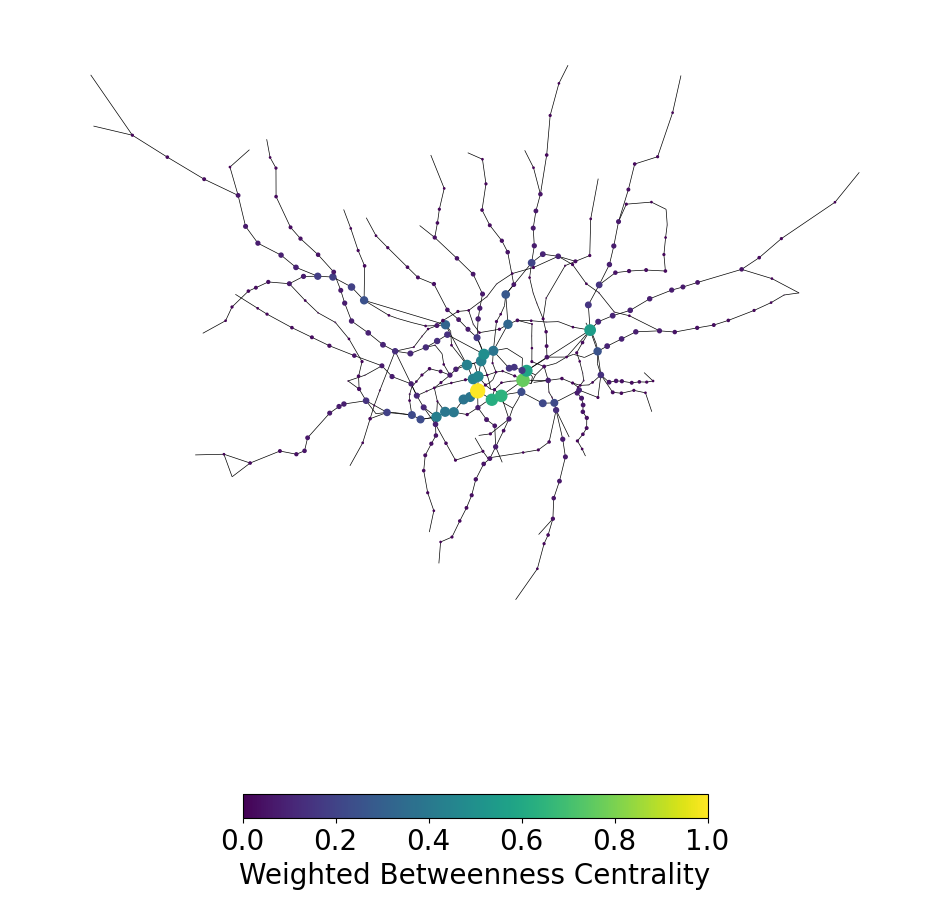

In [169]:
betweenness_w_values=[(i[1]['betweenness_w']) for i in G.nodes(data=True)]

bet_w_color=[(i[1]['betweenness_w']/max(betweenness_w_values)) for i in G.nodes(data=True)]
bet_w_size=[(i[1]['betweenness_w']/max(betweenness_w_values))*100 for i in G.nodes(data=True)]

pos=pos

fig, ax = plt.subplots(figsize=(12,12))

nx.draw_networkx_edges(G, pos,edge_color='black', 
        width=0.5)
nod=nx.draw_networkx_nodes(G,
        pos = pos,
        node_color= bet_w_color,
        node_size= bet_w_size)

plt.colorbar(nod,label="Weighted Betweenness Centrality",orientation="horizontal", shrink=0.5)
plt.axis("off")
# plt.title("London tube weighted betweenness centrality",fontsize=15)

# plt.savefig('Output/Figure3b.png', dpi=300)
plt.show()

In [165]:
bet_london=nx.betweenness_centrality(G, normalized=False)

nx.set_node_attributes(G,bet_london,'betweenness_t')

df = pd.DataFrame(index=G.nodes())
df['betweenness_t'] = pd.Series(nx.get_node_attributes(G, 'betweenness_t'))

df_sorted = df.sort_values(["betweenness_t"], ascending=False)
df_sorted[0:10]

,betweenness_t
Stratford,23768.093434
Bank and Monument,23181.058947
Liverpool Street,21610.387049
King's Cross St. Pancras,20373.521465
Waterloo,19464.882323
Green Park,17223.622114
Euston,16624.275469
Westminster,16226.155916
Baker Street,15287.107612
Finchley Road,13173.758009


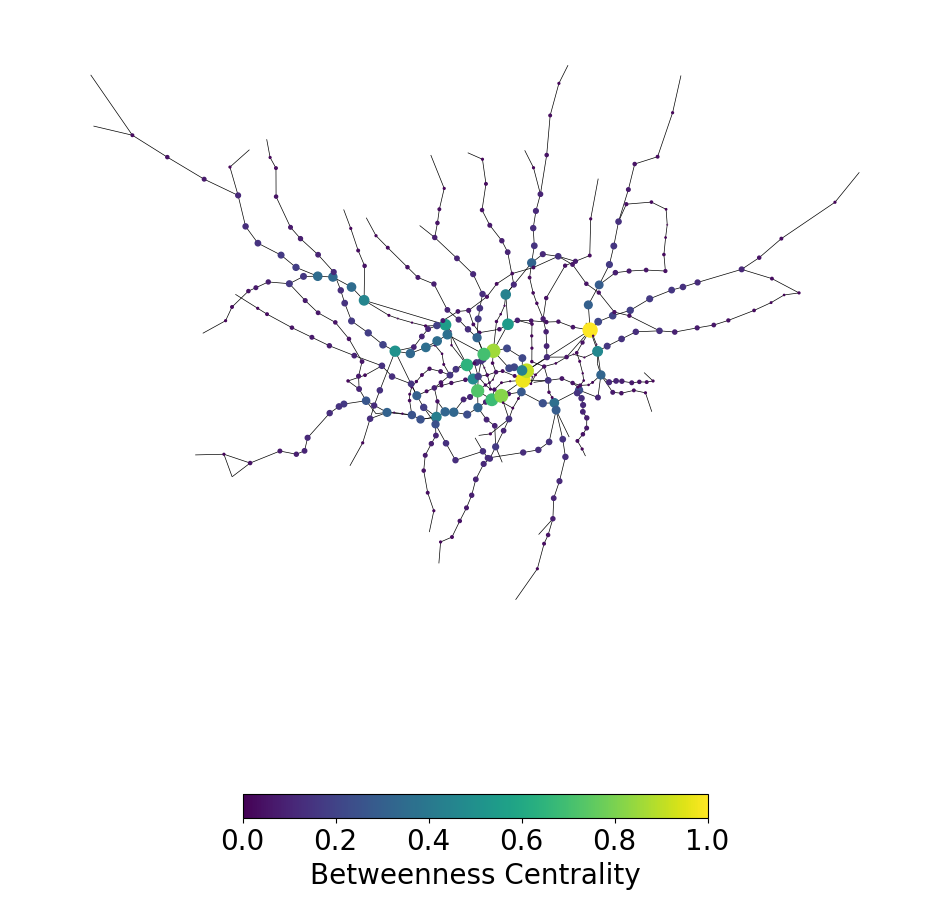

In [168]:
betweenness_t_values=[(i[1]['betweenness_t']) for i in G.nodes(data=True)]

bet_t_color=[(i[1]['betweenness_t']/max(betweenness_t_values)) for i in G.nodes(data=True)]
bet_t_size=[(i[1]['betweenness_t']/max(betweenness_t_values))*100 for i in G.nodes(data=True)]

fig, ax = plt.subplots(figsize=(12,12))

nx.draw_networkx_edges(G, pos,edge_color='black', width=0.5)

nod=nx.draw_networkx_nodes(G, pos = pos, node_color= bet_t_color, node_size= bet_t_size)

plt.colorbar(nod,label="Betweenness Centrality",orientation="horizontal", shrink=0.5)
plt.axis("off")
# plt.title("London tube topological betweenness centrality",fontsize=15)

# plt.savefig('Output/Figure3a.png', dpi=300)
plt.show()

## II.2. Impact measure with flows

In [265]:
# Calculate the global efficiency of Graph
def my_global_efficiency_w(Graph):
    n = len(Graph)
    denom = n * (n - 1)
    if denom != 0:
        lengths = nx.all_pairs_dijkstra_path_length(Graph, weight = 'new_weight')
        g_eff = 0
        for source, targets in lengths:
            for target, distance in targets.items():
                if distance > 0:
                    g_eff += 1 / distance
        g_eff /= denom
    else:
        g_eff = 0
        
    return g_eff

In [266]:
print(my_global_efficiency_w(G_un))

2699.277923189889


In [ ]:
# def rsmcs(g):
#     '''
#     This function is the second method to evaluate the impact on the network after nodes removal.
#     It gets the value of relative size of the maximal connected sub-graph.
#     '''
#     return len(max(nx.connected_components(g), key=len))/401

In [231]:
# # calculate the sum of strenght in the initial graph
s_initial=G_un.degree(weight='new_weight')
s_df=pd.DataFrame.from_dict(dict(s_initial),columns=['strenght'],orient='index')
s=s_df.strenght.sum()

In [232]:
s

0.17513955642274934

In [233]:
def rsmcs_weight(g):
    '''
    This function is the improved method to evaluate the impact on the network after nodes removal.
    It gets the value of relative size of the maximal connected sub-graph taking weight into consideration.
    '''
  
    # find the largest connected subgraph
    largest_cc = g.subgraph(max(nx.connected_components(g), key=len))
    
    # calculate the sum of strenght in this subgraph
    s_initial=largest_cc.degree(weight='new_weight')
    s_df=pd.DataFrame.from_dict(dict(s_initial),columns=['strenght'],orient='index')
    s_max=s_df.strenght.sum()
    
    return s_max/0.17513955642274934

In [277]:
################  non-seq  #################

# betweenness non-seq
bet_london_w=nx.betweenness_centrality(G_un,weight='new_weight', normalized=False)
betweenness_df=pd.DataFrame.from_dict(bet_london_w,columns=['betweenness_w'],orient='index')
node1=list(betweenness_df.sort_values('betweenness_w',axis = 0,ascending = False).index)
score_b_1=[]
scoreG_b_1=[]
g_1=G_un.copy()
for i in range(0,len(list(G_un.nodes))):
    score_b_1.append(rsmcs_weight(g_1))
    scoreG_b_1.append(my_global_efficiency_w(g_1))
    g_1.remove_nodes_from([node1[i]])

# closeness non-seq
closeness_w=nx.closeness_centrality(G_un,distance='new_weight')
closeness_df=pd.DataFrame.from_dict(closeness_w,columns=['closeness_w'],orient='index')
node2=list(closeness_df.sort_values('closeness_w',axis = 0,ascending = False).index)
score_b_2=[]
scoreG_b_2=[]
g_2=G_un.copy()
for i in range(0,len(list(G_un.nodes))):
    score_b_2.append(rsmcs_weight(g_2))
    scoreG_b_2.append(my_global_efficiency_w(g_2))
    g_2.remove_nodes_from([node2[i]])

# degree non-seq
degree=G_un.degree(weight='new_weight')
degree_df=pd.DataFrame.from_dict(dict(degree),columns=['degree'],orient='index')
node3=list(degree_df.sort_values('degree',axis = 0,ascending = False).index)
score_b_3=[]
scoreG_b_3=[]
g_3=G_un.copy()
for i in range(0,len(list(G_un.nodes))):
    score_b_3.append(rsmcs_weight(g_3))
    scoreG_b_3.append(my_global_efficiency_w(g_3))    
    g_3.remove_nodes_from([node3[i]])

    
##################      seq    ########################

#betweenness seq
score_b_4=[]
scoreG_b_4=[]
g_4=G_un.copy()
for i in range(0,len(list(G_un.nodes))):
    score_b_4.append(rsmcs_weight(g_4))
    scoreG_b_4.append(my_global_efficiency_w(g_4)) 
    bet_london_w=nx.betweenness_centrality(g_4, weight='new_weight',normalized=False)
    nx.set_node_attributes(g_4,bet_london_w,'betweenness_w')
    betweenness_df=pd.DataFrame.from_dict(bet_london_w,columns=['betweenness_w'],orient='index')
    node4=list(betweenness_df.sort_values('betweenness_w',axis = 0,ascending = False).index)
    g_4.remove_nodes_from([node4[0]])

# closeness seq
score_b_5=[]
scoreG_b_5=[]
g_5=G_un.copy()
for i in range(0,len(list(G_un.nodes))):
    score_b_5.append(rsmcs_weight(g_5))
    scoreG_b_5.append(my_global_efficiency_w(g_5))     
    closeness_w=nx.closeness_centrality(g_5,distance='new_weight')
    nx.set_node_attributes(g_5,closeness_w,'closeness_w')
    closeness_df=pd.DataFrame.from_dict(closeness_w,columns=['closeness_w'],orient='index')
    node5=list(closeness_df.sort_values('closeness_w',axis = 0,ascending = False).index)
    g_5.remove_nodes_from([node5[0]])
    
# degree seq
score_b_6=[]
scoreG_b_6=[]
g_6=G_un.copy()
for i in range(0,len(list(G_un.nodes))):
    score_b_6.append(rsmcs_weight(g_6))
    scoreG_b_6.append(my_global_efficiency_w(g_6))    
    degree=g_6.degree(weight='new_weight')
    nx.set_node_attributes(g_6,dict(degree),'degree')
    degree_df=pd.DataFrame.from_dict(dict(degree),columns=['degree'],orient='index')
    node6=list(degree_df.sort_values('degree',axis = 0,ascending = False).index)
    g_6.remove_nodes_from([node6[0]])

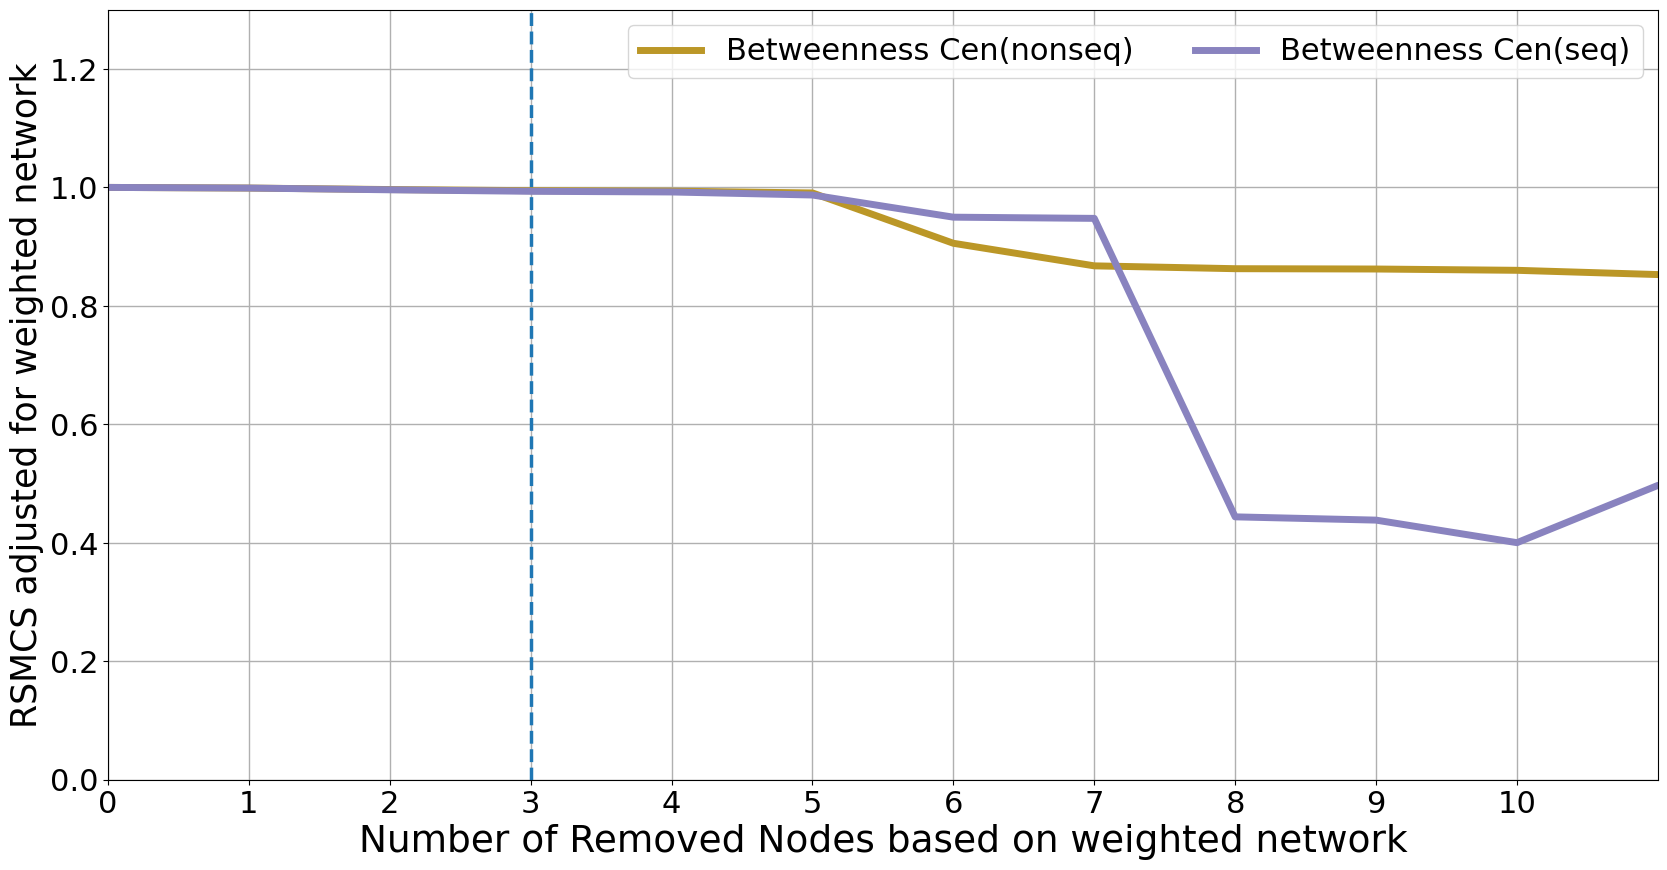

In [290]:
plt.style.use('default')
plt.subplots(figsize=(20,10))

plt.xlabel('Number of Removed Nodes based on weighted network',fontsize=27)
plt.ylabel('RSMCS adjusted for weighted network',fontsize=25)
plt.xticks(range(0,11,1), fontsize=22)
plt.yticks(fontsize=22)
x = range(0,401)

plt.plot([3,3],[0,1.3],'--',alpha=1,linewidth=2.5)
plt.grid(True, linewidth=1)

plt.xlim(xmax=11,xmin=0)
plt.ylim(ymax=1.3,ymin=0)

color1 = '#F27970'
color2 = '#BB9727'
color3 = '#54B345' 
color4 = '#05B9E2'
color5 = '#8983BF'
color6 = '#C76DA2'

# plt.plot(x, score_b_3, color=color1,label='Degree Cen(nonseq)', linewidth=5, markersize=10)
plt.plot(x, score_b_1, color=color2,label='Betweenness Cen(nonseq)', linewidth=5, markersize=10)
# plt.plot(x, score_b_2, color=color3, label='Closeness Cen(nonseq)', linewidth=5, markersize=10)

# plt.plot(x, score_b_6, color=color4, label='Degree Cen(seq)', linewidth=5, markersize=10)
plt.plot(x, score_b_4, color=color5,label='Betweenness Cen(seq)', linewidth=5, markersize=10)
# plt.plot(x, score_b_5, color=color6, label='Closeness Cen(seq)', linewidth=5, markersize=10)


plt.legend(loc=1,ncol=2,fontsize=22)
plt.savefig('Output/Figure4b.png', dpi=300)
plt.show()

In [279]:
scoreG_b_1 =  NormalizeData(scoreG_b_1[0:100])
scoreG_b_2 =  NormalizeData(scoreG_b_2[0:100])
scoreG_b_3 =  NormalizeData(scoreG_b_3[0:100])
scoreG_b_4 =  NormalizeData(scoreG_b_4[0:100])
scoreG_b_5 =  NormalizeData(scoreG_b_5[0:100])
scoreG_b_6 =  NormalizeData(scoreG_b_6[0:100])

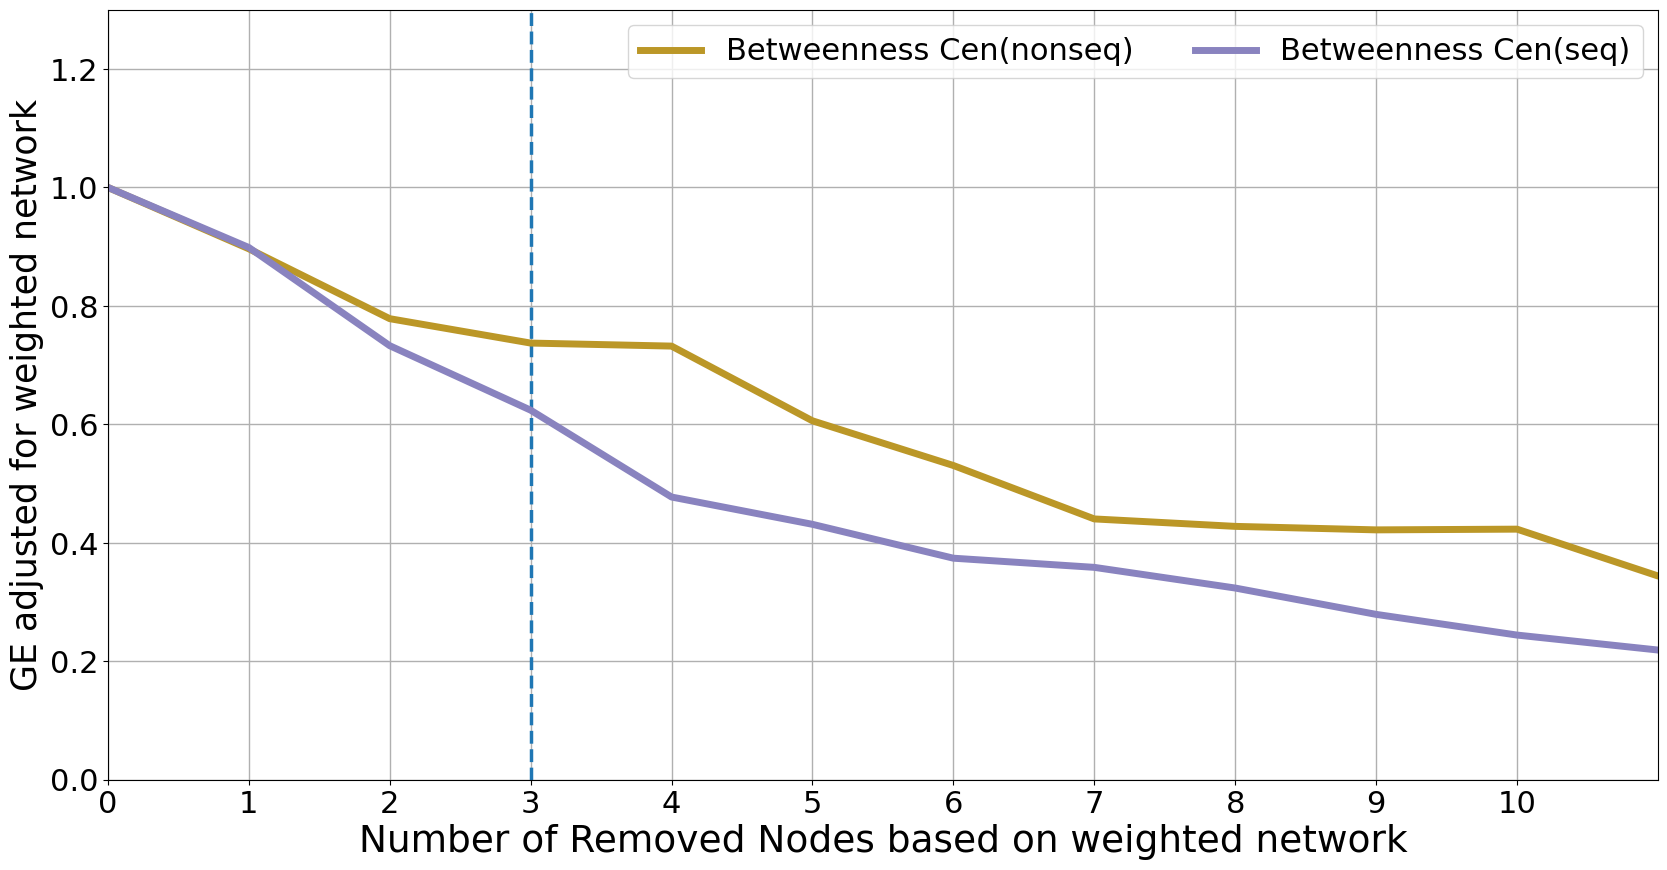

In [324]:
plt.style.use('default')
plt.subplots(figsize=(20,10))

plt.xlabel('Number of Removed Nodes based on weighted network',fontsize=27)
plt.ylabel('GE adjusted for weighted network',fontsize=25)
plt.xticks(range(0,11,1), fontsize=22)
plt.yticks(fontsize=22)
x = range(0,100)

plt.plot([3,3],[0,1.3],'--',alpha=1,linewidth=2.5)
plt.grid(True, linewidth=1)

plt.xlim(xmax=11,xmin=0)
plt.ylim(ymax=1.3,ymin=0)

color1 = '#F27970'
color2 = '#BB9727'
color3 = '#54B345' 
color4 = '#05B9E2'
color5 = '#8983BF'
color6 = '#C76DA2'

# plt.plot(x, scoreG_b_3, color=color1,label='Degree Cen(nonseq)', linewidth=5, markersize=10)
plt.plot(x, scoreG_b_1, color=color2,label='Betweenness Cen(nonseq)', linewidth=5, markersize=10)
# plt.plot(x, scoreG_b_2, color=color3, label='Closeness Cen(nonseq)', linewidth=5, markersize=10)

# plt.plot(x, scoreG_b_6, color=color4, label='Degree Cen(seq)', linewidth=5, markersize=10)
plt.plot(x, scoreG_b_4, color=color5,label='Betweenness Cen(seq)', linewidth=5, markersize=10)
# plt.plot(x, scoreG_b_5, color=color6, label='Closeness Cen(seq)', linewidth=5, markersize=10)


plt.legend(loc=1,ncol=2,fontsize=22)
# plt.savefig('Output/Figure4a.png', dpi=300)
plt.show()

# 🛡️Part 2: Spatial Interaction models

# **III. Models and calibration**

## III.1. Spatial interaction models

## III.2. Calibration of model

# **IV. Scenarios**

## IV.1. Scenario A

## IV.2. Scenario B

## IV.3. Analysis